<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="UTF-8" />
        <meta http-equiv="X-UA-Compatible" content="IE=edge" />
        <meta name="viewport" content="width=device-width, initial-scale=1.0" />
        <title>UAS NLP</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                background-color: #f0f0f0;
                margin: 0;
                padding: 0;
            }
            .container {
                text-align: center;
                margin-top: 50px;
            }
            h1 {
                color: #fff; /* Adjusted color for dark mode */
                font-size: 36px;
                margin-bottom: 10px;
            }
            h2 {
                color: #ccc; /* Adjusted color for dark mode */
                font-size: 24px;
                margin-bottom: 20px;
            }
            .members {
                font-size: 18px;
                line-height: 1.6;
                margin-top: 20px;
            }
            .member {
                display: block;
                margin-bottom: 10px;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Ujian Akhir Semester</h1>
            <h2>IBDA3322 / Natural Language Processing</h2>
            <p class="members">
                <span class="member">Jennifer Atalya (202000208)</span>
                <span class="member">Renata Valencia (202001021)</span>
                <span class="member">Stefannus Christian (202000138)</span>
            </p>
        </div>
    </body>
</html>

# Import Libraries

In [1]:
# Import libraries
from transformers import (
    MBart50TokenizerFast,
    MBartForConditionalGeneration,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
import csv
import re
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import evaluate
from datasets import load_dataset
import warnings
# Ignore warnings (not recommended for production)
warnings.filterwarnings('ignore')

# Define Global Variables

In [2]:
# Define training parameters
TRAIN: bool = True  # Set to True to train the model
SEED = 42  # Random seed for reproducibility

# Define model and data paths
MODEL_PATH = "model/mbart-large-50-one-to-many-mmt-finetuned-en-to-id"
NUMBER_OF_DATA_TO_FINETUNED = 2000  # Limit data used for fine-tuning
PREFIX = ""  # Prefix to add before source language text
SOURCE_LANG = "en"  # Source language
TARGET_LANG = "id"  # Target language
MAX_INPUT_LENGTH = 128  # Maximum length of input sequence
MAX_TARGET_LENGTH = 128  # Maximum length of target sequence

TRAINING_RESULTS_DIRECTORY_BASE_PATH = "./training_results/"
TRAINING_RESULTS_FILENAME = "training_results.csv"
LOG_RESULTS_FILENAME = "log.pkl"

TRAINING_RESULTS_PATH = os.path.join(TRAINING_RESULTS_DIRECTORY_BASE_PATH, TRAINING_RESULTS_FILENAME)
LOG_RESULTS_PATH = os.path.join(TRAINING_RESULTS_DIRECTORY_BASE_PATH, LOG_RESULTS_FILENAME)

print(f'Will save training results csv to {TRAINING_RESULTS_PATH}')
print(f'Will save log results (log_history, bleu_log, meteor_log, eval_log) to {LOG_RESULTS_PATH}')

Will save training results csv to ./training_results/training_results.csv
Will save log results (log_history, bleu_log, meteor_log, eval_log) to ./training_results/log.pkl


# Load Raw Datasets

In [3]:
# Load dataset
raw_datasets = load_dataset("Helsinki-NLP/opus-100", "en-id")
model_mbart = 'facebook/mbart-large-50-one-to-many-mmt'
display(raw_datasets)  # View dataset information

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [4]:
# Load tokenizer for the pre-trained model
tokenizer = MBart50TokenizerFast.from_pretrained(
    model_mbart, src_lang="en_XX", tgt_lang="id_ID"
)

In [5]:
def lowercase_text(text: str) -> str:
    text = text.lower()
    return text

def remove_extra_spaces(text :str) -> str:
    """
    Removes extra spaces from a string using regular expression.

    Args:
    - text (str): The input text with extra spaces.

    Returns:
    - str: The text with extra spaces removed.
    """
    # Use regular expression to substitute multiple spaces with a single space
    cleaned_text = re.sub(' +', ' ', text)
    return cleaned_text.strip()

def preprocess_function(examples):
    """
    Preprocess data examples:
        - Add prefix to source language text
        - Lowercase source language text
        - Remove extra spaces from source and target language text
        - Encode text with tokenizer
    """
    # Lowercase source language text and remove extra spaces
    inputs = [PREFIX + lowercase_text(remove_extra_spaces(ex[SOURCE_LANG])) for ex in examples["translation"]]
    # Lowercase target language text and remove extra spaces
    targets = [lowercase_text(remove_extra_spaces(ex[TARGET_LANG])) for ex in examples["translation"]]

    model_inputs = tokenizer(
        inputs, max_length=MAX_INPUT_LENGTH, truncation=True)

    # Set tokenizer for target language
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets, max_length=MAX_TARGET_LENGTH, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [6]:
lowercase_text(remove_extra_spaces("  The     quICk brown    FOX "))

'the quick brown fox'

In [7]:
# Preprocess dataset
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

# Split datasets into train and validation sets
train_tokenized_dataset = tokenized_datasets["train"]
eval_tokenized_dataset = tokenized_datasets["validation"]
print(f"Number of train tokenized data: {len(train_tokenized_dataset)}")
print(f"Number of eval tokenized data: {len(eval_tokenized_dataset)}")

# Select a small subset of data for fine-tuning (for faster training)
small_train_dataset = train_tokenized_dataset.shuffle(
    seed=SEED).select(range(NUMBER_OF_DATA_TO_FINETUNED))
small_eval_dataset = eval_tokenized_dataset.shuffle(
    seed=SEED).select(range(NUMBER_OF_DATA_TO_FINETUNED))

print(f"Number of small_train_dataset {len(small_train_dataset)}")
print(f"Number of small_eval_dataset {len(small_eval_dataset)}")

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Number of train tokenized data: 1000000
Number of eval tokenized data: 2000
Number of small_train_dataset 2000
Number of small_eval_dataset 2000


In [8]:
# Load pre-trained model (make sure to use 'cuda' for GPU training)
model = MBartForConditionalGeneration.from_pretrained(model_mbart).cuda()

In [9]:
# Define training hyperparameters
hyperparameters = {
    'learning_rate': 2e-5,
    'batch_size': 8,
    'num_epochs': 10
}

# Define training arguments (`Seq2SeqTrainingArguments`)
args = Seq2SeqTrainingArguments(
    # Create a name for your fine-tuned model
    f"{MODEL_PATH.split('/')[-1]}-finetuned-{SOURCE_LANG}-to-{TARGET_LANG}",
    # Evaluate the model after every epoch
    evaluation_strategy="epoch",
    # Save the model after every epoch
    save_strategy="epoch",
    # Set learning rate from hyperparameters
    learning_rate=hyperparameters["learning_rate"],
    # Batch size for training on a single device
    per_device_train_batch_size=hyperparameters["batch_size"],
    # Batch size for evaluation on a single device
    per_device_eval_batch_size=hyperparameters["batch_size"],
    # Weight decay to avoid overfitting
    weight_decay=0.01,
    # Limit number of saved models during training
    save_total_limit=hyperparameters["num_epochs"],
    # Set the total number of training epochs
    num_train_epochs=hyperparameters["num_epochs"],
    # Generate text with beam search during evaluation
    predict_with_generate=True,
    # Load the best model from the training process for evaluation
    load_best_model_at_end=True,
)

In [10]:
# Create a data collator to prepare batches for training and evaluation
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [11]:
# Load evaluation metrics: BLEU score and METEOR
metric = evaluate.load("sacrebleu")
meteor = evaluate.load('meteor')

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(
        decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels)
    meteor_result = meteor.compute(
        predictions=decoded_preds, references=decoded_labels)
    prediction_lens = [np.count_nonzero(
        pred != tokenizer.pad_token_id) for pred in preds]
    result = {'bleu': result['score']}
    result["gen_len"] = np.mean(prediction_lens)
    result["meteor"] = meteor_result["meteor"]
    result = {k: round(v, 4) for k, v in result.items()}
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
if not os.path.exists(TRAINING_RESULTS_PATH):
    os.makedirs(TRAINING_RESULTS_PATH)

if TRAIN:

    trainer = Seq2SeqTrainer(
        model,
        args,
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        data_collator=data_collator,

        tokenizer=tokenizer,

        compute_metrics=compute_metrics,

        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    trainer.train()

    trainer.save_model(MODEL_PATH)


    log_history = pd.DataFrame(trainer.state.log_history)

    bleu_log = log_history["eval_bleu"].dropna().to_list()

    meteor_log = log_history["eval_meteor"].dropna().to_list()

    eval_log = log_history["eval_loss"].dropna().to_list()

    # Save the variables using pickle

    with open(LOG_RESULTS_PATH, "wb") as f:

        pickle.dump((log_history, bleu_log, meteor_log, eval_log), f)

else:

    # Load the saved variables using pickle

    with open(LOG_RESULTS_PATH, "rb") as f:

        log_history, bleu_log, meteor_log, eval_log = pickle.load(f)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.91679048538208, 'eval_bleu': 25.7045, 'eval_gen_len': 13.064, 'eval_meteor': 0.5156, 'eval_runtime': 107.2817, 'eval_samples_per_second': 18.643, 'eval_steps_per_second': 2.33, 'epoch': 1.0}
{'loss': 1.7212, 'grad_norm': 7.261785984039307, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}


  0%|          | 0/250 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.9522719383239746, 'eval_bleu': 25.6988, 'eval_gen_len': 12.81, 'eval_meteor': 0.5098, 'eval_runtime': 105.7829, 'eval_samples_per_second': 18.907, 'eval_steps_per_second': 2.363, 'epoch': 2.0}


  0%|          | 0/250 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 2.091963291168213, 'eval_bleu': 25.1044, 'eval_gen_len': 12.8095, 'eval_meteor': 0.5069, 'eval_runtime': 102.3342, 'eval_samples_per_second': 19.544, 'eval_steps_per_second': 2.443, 'epoch': 3.0}


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'train_runtime': 478.3445, 'train_samples_per_second': 41.811, 'train_steps_per_second': 5.226, 'train_loss': 1.4489441731770833, 'epoch': 3.0}


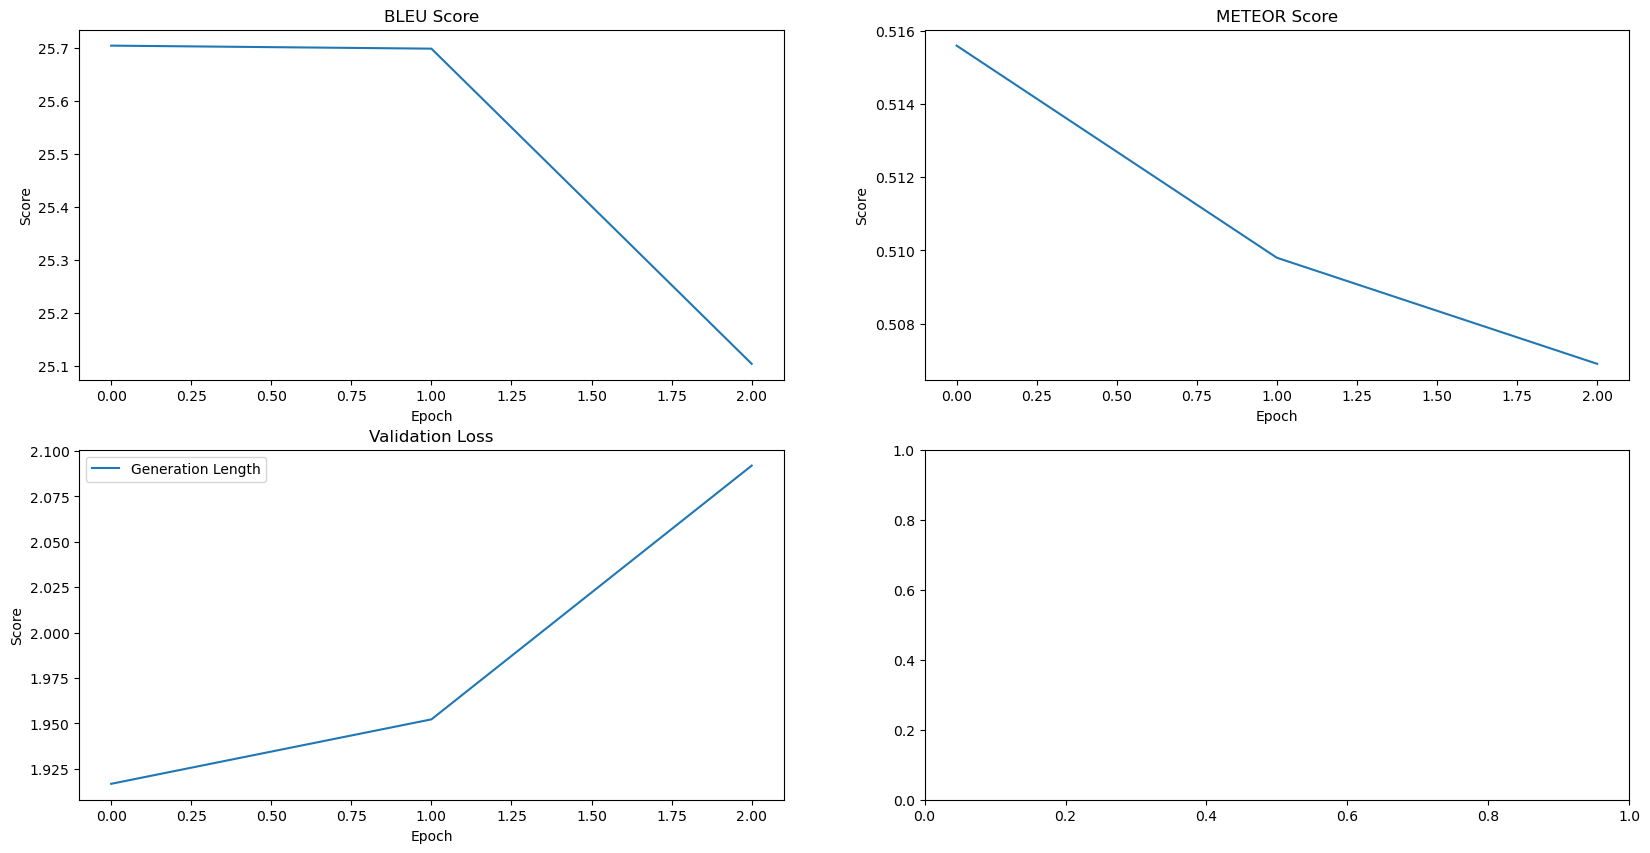

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(range(len(bleu_log)), bleu_log, label='BLEU Score')
plt.title("BLEU Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(2, 2, 2)
plt.plot(range(len(meteor_log)), meteor_log, label='METEOR Score')
plt.title("METEOR Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(2, 2, 3)
plt.plot(range(len(eval_log)), eval_log, label='Generation Length')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.legend()
plt.show()

In [14]:
rows = []
for i in range(len(bleu_log)):
    row = {
        'Epoch': i+1,
        'BLEU': bleu_log[i],
        'METEOR': meteor_log[i],
        'validation_loss': eval_log[i],
    }
    rows.append(row)

# Define the fieldnames for the CSV file
fieldnames = ['Epoch', 'BLEU', 'METEOR', 'validation_loss']

# Write the rows to a CSV file
with open(TRAINING_RESULTS_PATH, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)

In [19]:
tokenizer = MBart50TokenizerFast.from_pretrained(MODEL_PATH, src_lang="en_XX")
model = MBartForConditionalGeneration.from_pretrained(MODEL_PATH).cuda()

src_text =  "This model is a fine-tuned checkpoint of mBART-large-50. mbart-large-50-many-to-many-mmt is fine-tuned for multilingual machine translation. It was introduced in Multilingual Translation with Extensible Multilingual Pretraining and Finetuning paper."

src_text = src_text.replace("!",".")
src_text = lowercase_text(remove_extra_spaces(src_text))
sentences = [(sentence+". ").strip() for sentence in src_text.split(".") if len(sentence) > 0]
print(sentences)

translation_results = ""
for sentence in sentences:
    model_inputs = tokenizer(sentence, return_tensors="pt").to("cuda")

    generated_tokens = model.generate(
        **model_inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id["id_ID"],
    )

    translation = tokenizer.batch_decode(
        generated_tokens, skip_special_tokens=True)
    translation_results += translation[0].strip()

print()
print(translation_results)

['this model is a fine-tuned checkpoint of mbart-large-50.', 'mbart-large-50-many-to-many-mmt is fine-tuned for multilingual machine translation.', 'it was introduced in multilingual translation with extensible multilingual pretraining and finetuning paper.']

model ini adalah periksa dari mbart-large-50.mbart-large-50-many-to-many-mmt tersusun untuk penerjemah mesin multilingual.ini diperkenalkan pada penerjemahan multilingual dengan ekstensible multilingual pretraining dan kertas finetuning.
